In [ ]:
%%time
import keras.applications as ka
import os
from keras.utils import to_categorical
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from keras.applications.imagenet_utils import decode_predictions
from skimage.transform import resize
# need to look deeper into this
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, precision_score, recall_score, classification_report
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from skimage.io import imread, imsave
import skimage
import numpy as np
import scipy
from skimage.color import gray2rgb
from keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16 
from keras.applications.vgg19 import preprocess_input as preprocess_vgg19
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Labels Imagenet 1000 classes
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
# https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
# https://github.com/calebrob6/imagenet_validation/blob/master/1.%20Preprocess%20ImageNet%20validation%20set.ipynb
# wget http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_val.tar
# 
# https://raw.githubusercontent.com/soumith/imagenetloader.torch/master/valprep.sh

In [2]:
#escuro
def gamma8(img):
    return exposure.adjust_gamma(img, 8.)
def gamma4(img):
    return exposure.adjust_gamma(img, 4.)
def gamma2(img):
    return exposure.adjust_gamma(img, 2.)
#claro
def gamma18(img):
    return exposure.adjust_gamma(img, 1./8.)
def gamma14(img):
    return exposure.adjust_gamma(img, 1./4.)
def gamma12(img):
    return exposure.adjust_gamma(img, 1./2.)

#


def open_image(image_path):
    # load
    img = imread(image_path)
    if len(img.shape)==2:
        img = gray2rgb(img)
    return img

def resize_crop(img, size):
    # Resize
    if size == 224:
        height, width, _ = img.shape
        new_height = height * 256 // min(img.shape[:2])
        new_width = width * 256 // min(img.shape[:2])
        img = resize(img, (new_width, new_height))
fns = [VALIDATION_FOLDER + fn for fn in fns]
        # Crop
        height, width, _ = img.shape
        startx = width//2 - (224//2)
        starty = height//2 - (224//2)
        img = img[starty:starty+224,startx:startx+224]
        assert img.shape[0] == 224 and img.shape[1] == 224, (img.shape, height, width)
        
    elif size == 299:
        height, width, _ = img.shape
        new_height = height * 340 // min(img.shape[:2])
        new_width = width * 340 // min(img.shape[:2])
        img = resize(img, (new_width, new_height))

        # Crop
        height, width, _ = img.shape
        startx = width//2 - (299//2)
        starty = height//2 - (299//2)
        img = img[starty:starty+299,startx:startx+299]
        assert img.shape[0] == 299 and img.shape[1] == 299, (img.shape, height, width)

    elif size == 331:
        height, width, _ = img.shape
        new_height = height * 350 // min(img.shape[:2])
        new_width = width * 350 // min(img.shape[:2])
        img = resize(img, (new_width, new_height))

        # Crop
        height, width, _ = img.shape
        startx = width//2 - (331//2)
        starty = height//2 - (331//2)
        img = img[starty:starty+331,startx:startx+331]
        assert img.shape[0] == 331 and img.shape[1] == 331, (img.shape, height, width)
        
    return img
    

In [17]:
def add_noise(image, noise_typ = "gauss", mean = 0, var = 555, exp_sigma = 0.5, percent = 1):
    
    if noise_typ == "gauss":
        row,col,ch= image.shape
        #mean = 0
        #var = 0.1
        sigma = ((percent**2)*var)**exp_sigma
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        noisy = np.clip(noisy, .0, 255.)
        return noisy
    
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.3
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        out = np.clip(out, .0, 255.)
        return out
    
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image/255. * vals) / float(vals)
        noisy = np.clip(noisy*255., .0, 255.)
        return noisy
    
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        noisy = np.clip(noisy, .0, 255.)
        return noisy
    elif noise_typ == "glare":
        print('Not yet implemented')
        
def compression(rgb, ftype='.jpg', quality=15):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encimg = cv2.imencode(ftype, rgb, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg

In [4]:
%%time
# 
VALIDATION_FOLDER = "/media/messias/SSD2/deepdive/datasets/ILSVRC2012_img_val/"

fns = os.listdir(VALIDATION_FOLDER); fns.sort()
fns = [VALIDATION_FOLDER + fn for fn in fns]

print("Found " +str(len(fns)) + " files")

Found 50001 files
CPU times: user 29.3 ms, sys: 28.9 ms, total: 58.2 ms
Wall time: 56.6 ms


In [5]:
%%time
# Labels Validation
y_true = np.load(VALIDATION_FOLDER + "y_val.npy")
y_true = to_categorical(y_true, 1000)
print("Found " +str(y_true.shape[0]) + " labels")


Found 50000 labels
CPU times: user 14.1 ms, sys: 37.5 ms, total: 51.6 ms
Wall time: 49.7 ms


In [6]:
%%time
model_list = [
    # input shape (299, 299, 3)
    ["ka.inception_v3.InceptionV3(weights='imagenet', include_top=True)",299],

    # input shape (299, 299, 3)
    ["ka.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)",299],

    # input shape (224, 224, 3)
    ["ka.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)",224,'preprocess_resnet50'],

    #input shape (299, 299, 3)
    ["ka.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)",299],

    # input shape (224, 224, 3)
    ["ka.mobilenet.MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)",224],

    # input shape (224, 224, 3)
    #["ka.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)",224],
    #["ka.densenet.DenseNet169(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)",224],
    ["ka.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)",224],

    # input shape (224, 224, 3)
    ["ka.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)",224],

    # input shape (331, 331, 3)
    ["ka.nasnet.NASNetLarge(input_shape=None, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)",331],
    # input shape (224, 224, 3)
    ["ka.nasnet.NASNetMobile(input_shape=None, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)",224],

    # input shape (224, 224, 3)
    ["ka.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)",224,'preprocess_vgg16'],
    ["ka.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)",224,'preprocess_vgg19']
    ]


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


In [ ]:
distortion_list = ['gauss','speckle','poisson','s&p']

ka.inception_v3.InceptionV3(weights='imagenet', include_top=True)
Image:  0


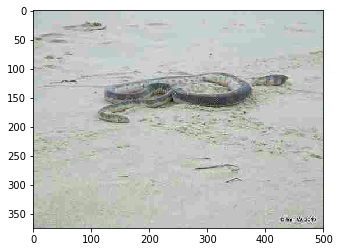

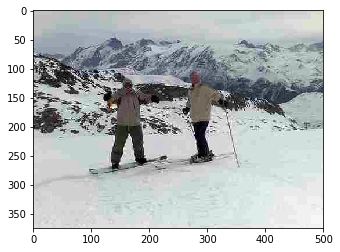

(2, 1000) vs  (2, 1000)
TOP1 ; 0.5
TOP3 ; 1.0
TOP5 ; 1.0
RECALL ; 0.5
ACC ; 0.5
F1 ; 0.5
ka.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
Image:  0


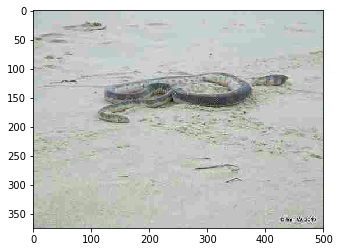

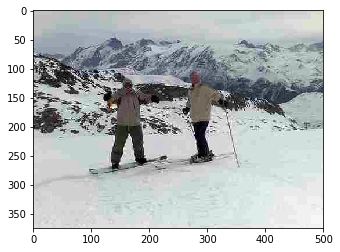

(2, 1000) vs  (2, 1000)
TOP1 ; 0.5
TOP3 ; 1.0
TOP5 ; 1.0
RECALL ; 0.5
ACC ; 0.5
F1 ; 0.5
ka.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
Image:  0


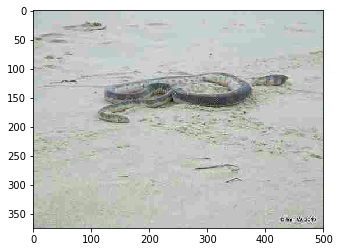

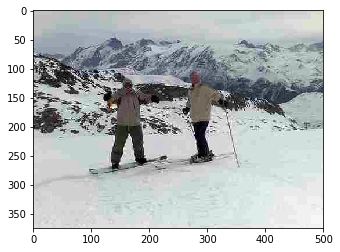

(2, 1000) vs  (2, 1000)
TOP1 ; 0.5
TOP3 ; 0.5
TOP5 ; 1.0
RECALL ; 0.5
ACC ; 0.5
F1 ; 0.5
ka.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
Image:  0


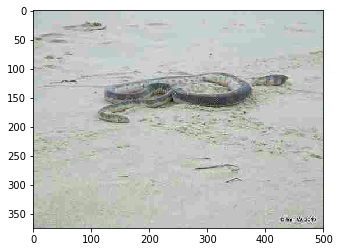

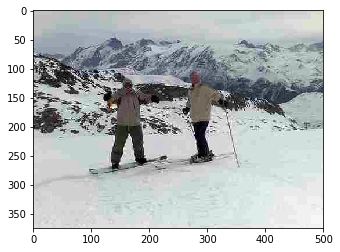

(2, 1000) vs  (2, 1000)
TOP1 ; 0.5
TOP3 ; 1.0
TOP5 ; 1.0
RECALL ; 0.5
ACC ; 0.5
F1 ; 0.5
ka.mobilenet.MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
Image:  0


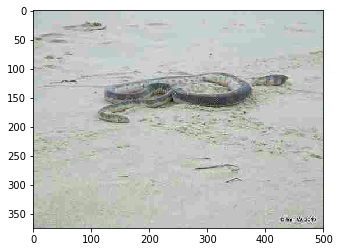

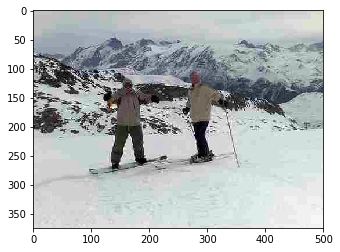

(2, 1000) vs  (2, 1000)
TOP1 ; 0.0
TOP3 ; 0.5
TOP5 ; 0.5
RECALL ; 0.0
ACC ; 0.0
F1 ; 0.0
ka.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
Image:  0


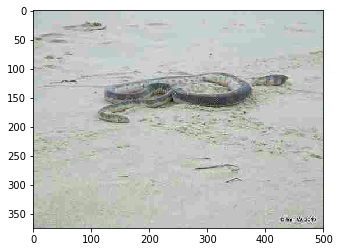

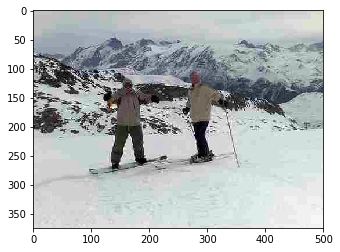

(2, 1000) vs  (2, 1000)
TOP1 ; 0.0
TOP3 ; 1.0
TOP5 ; 1.0
RECALL ; 0.0
ACC ; 0.0
F1 ; 0.0
ka.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
Image:  0


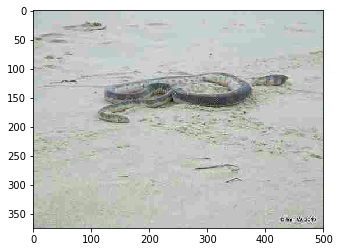

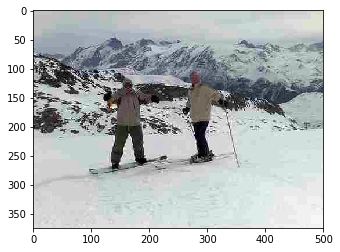

(2, 1000) vs  (2, 1000)
TOP1 ; 0.0
TOP3 ; 1.0
TOP5 ; 1.0
RECALL ; 0.0
ACC ; 0.0
F1 ; 0.0
ka.nasnet.NASNetLarge(input_shape=None, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)


In [ ]:
#%%time
%matplotlib inline 
d = 'compression'
for m in model_list:
    print(m[0])
    #for d in distortion_list:
    #    print("Distortion: ", d)
    K.reset_uids()
    K.clear_session()
    model = eval(m[0])
    y_pred = []

    #for i in range(len(y_true)):
    for i in range(2):
        if i % 1000 == 0:
            print("Image: ", i)
        img = open_image(fns[i])
        #print(np.amax(img))

        #if(len(d)>1):
            #img = np.uint8(eval('add_noise(img, "'+ d +'")'))
        img = compression(img)
        plt.imshow(img)
        plt.show()

        if(len(m)>2):
            if(len(m[2])>1):
                img = eval(m[2]+'(img)')

        img = resize_crop(img, m[1])
        res = model.predict(np.expand_dims(img,0))
        y_pred.append(res[0])

    y_true = np.array(y_true[:2])
    y_pred = np.array(y_pred)
    print(y_true.shape, "vs ", y_pred.shape)
    stats = [
        K.get_session().run(top_k_categorical_accuracy(y_true, y_pred, k=1)),
        K.get_session().run(top_k_categorical_accuracy(y_true, y_pred, k=3)),
        K.get_session().run(top_k_categorical_accuracy(y_true, y_pred, k=5)),
        recall_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1),average="weighted"),
        precision_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1),average="weighted"),
        f1_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1),average="weighted"),
    ]
    cm = confusion_matrix(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))
    print("TOP1 ;", stats[0]);print("TOP3 ;", stats[1]);print("TOP5 ;", stats[2])
    print("RECALL ;", stats[3]);print("ACC ;", stats[4]);print("F1 ;", stats[5])
    #print("Confusion Matrix:\n", cm)

    pd.DataFrame(stats).to_csv("__" + d + "_" + m[0][3:20] + "_stats.csv", header=False)
    pd.DataFrame(cm).to_csv("__" + d + "_" + m[0][3:20]+"_cm.csv", header=False)

